In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os

In [2]:
def read_trace_file(f):
    trace = []

    for line in f:
        trace.append(float(line[:-1]))

    return trace

traces = []

directory    = "ELMO/output/traces/"
lst          = os.listdir(directory) # your directory path
num_traces   = len(lst)
                   

for i in range(1, num_traces + 1):
    f     = open(directory + "trace" + f'{str(i):0>5}' + ".trc", "r")
    trace = read_trace_file(f)
    
    traces.append(trace)

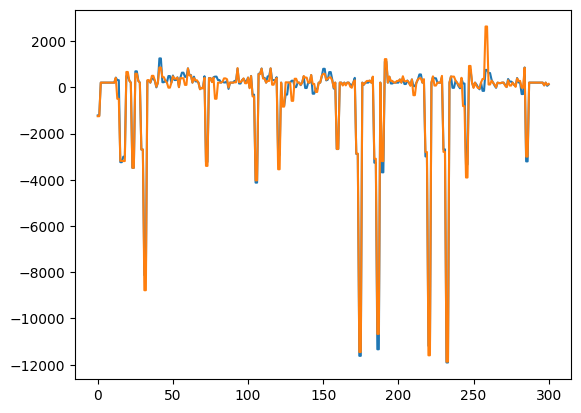

In [3]:
plt.plot(traces[0])
plt.plot(traces[1])

In [4]:
print(len(traces[0]))

301


In [5]:
def evaluate_corr(traces,hyp_pwr):
    
    num_samples    = np.shape(traces)[1]
    traces_hyp_pwr = np.concatenate((traces,hyp_pwr),axis=1)
    corr_matrix    = np.corrcoef(traces_hyp_pwr.T)
    
    return corr_matrix[num_samples,0:num_samples]

10000
10000
10000
10000
10000
10000
10000
10000


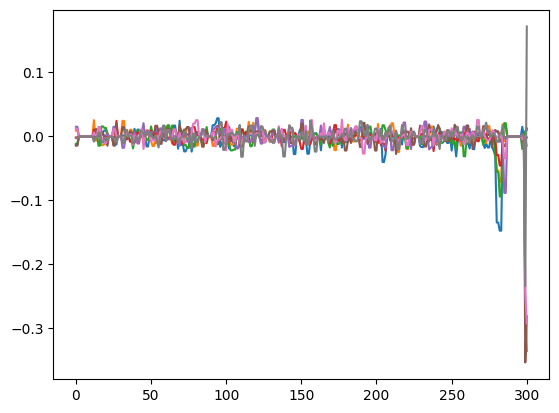

In [6]:
outputfile = 'ELMO/output/output.txt'

f = open(outputfile, "r")
lines = f.readlines()

for byte_position in range(8):
    outputs = []
    count   = 0
    for line in lines:
        count = count + 1
        if (count % 5 == 0):
            #print(line[:-1].split(' '))
            outputs.append(int((line[:-1].split(' ')[byte_position]), 16))

    print(len(outputs))

    plt.plot(evaluate_corr(np.array(traces[0:num_traces]),np.array(outputs[0:num_traces]).reshape(-1,1)))